# Example: Filling grids with (distinct) polyominos 

This GAMS program is about polyominos. These are two-dimensional figures consisting of some units (1x1 squares). These units are connected at the edges. To better imagine them, the picture below shows how so-called pentominos (polyominos consiting of five units) look like.

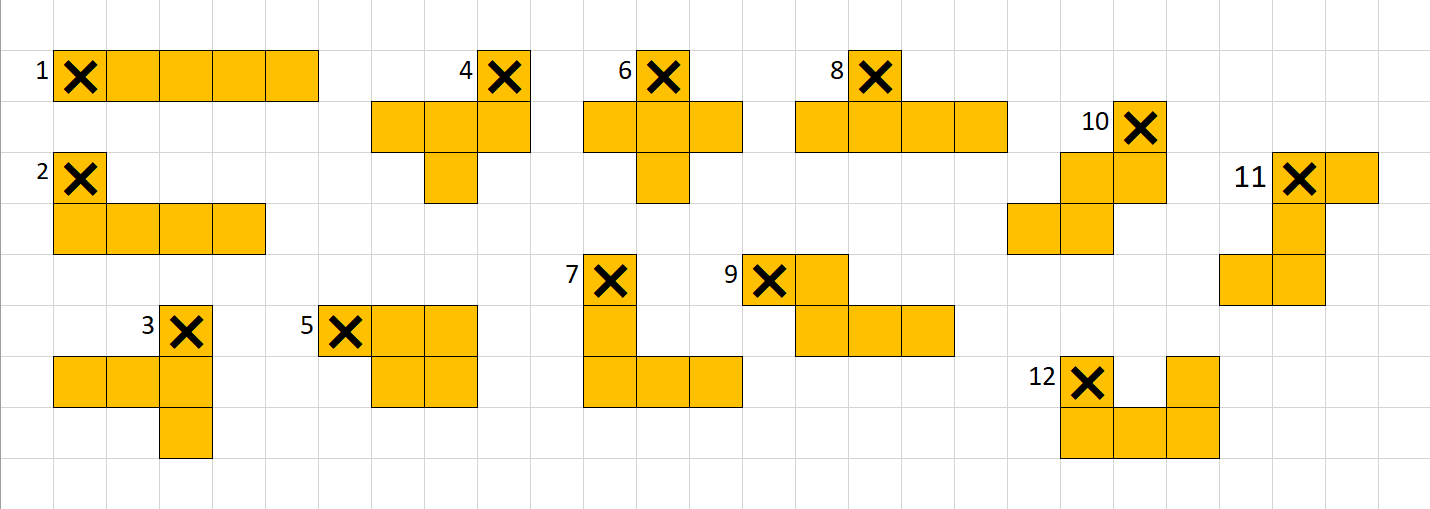

In [1]:
from IPython.display import Image
Image(filename="Pentominos.png")

As you can see, every polyomino has one marked unit which during the following steps is necessary. It could be called the root of a polyomino. There are twelve different pentominos if reflections and rotations are not specified. The issue is now to fill at the best a grid using some of these polyominos. <a href=#symm target=blank>Here</a> it is possible to exclude both considering the symmetries and using a polyomino only once.

### The algebraic model

Before starting to explain the GAMS code, the model, based on <a href=#References target=blank>[1]</a>, is presented. 

Objective function:
\begin{equation}
  \sum_{(i,j)}y(i,j) \rightarrow \text{max}
\end{equation}

Constraint ensuring that at $(i,j)$ there is no overlapping. For a better understanding of the here appearing set $cover$ see the implementation <a href=#ConstructingCover target=blank>below</a>.
\begin{equation}
    \forall (i,j): \ \ \ y_{i,j} = \sum_{(i,j,p,s)|_{cover(i,j,p,s,i',j')}}x_{p,s,i,j} 
\end{equation}

Alternative constraint to avoid repeated use of one polyomino:
\begin{equation}
    \forall p: \ \ \ \sum_{i,j,s}x_{p,s,i,j} \le 1
\end{equation}

Definition of the $x$ and the $y$ variables:
\begin{equation}
  x_{p,s,i,j} =
    \begin{cases}
      1 & \text{if polyomino $p$ with its symmetry $s$ has its root at $(i,j)$}\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

\begin{equation}
  y_{i,j} =
    \begin{cases}
      1 & \text{if $(i,j)$ is covered by a figure }\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}



### Implementation in GAMS

In [2]:
%load_ext gams_magic

#### Including polyominos

First it is possible to enter arbitrary polyominos. You can do this in the way presented below, i.e. 1 stands for that you want to use the according unit for your polyomino. Otherwise you leave the table entry empty. Note that rotations and the reflections as well can automatically included at the next step. You can add as many polyominos as you like.

In [3]:
%%gams

set p, xs, ys;
table tab(p<,xs<,ys<) 
        y1  y2  y3  y4  y5 
p1.x1   1   1   1   1   1 

p2.x1   1      
p2.x2   1   1   1   1

p3.x1           1   
p3.x2   1   1   1
p3.x3           1

p4.x1           1
p4.x2   1   1   1
p4.x3       1

p5.x1   1   1   1
p5.x2       1   1

p6.x1       1   
p6.x2   1   1   1
p6.x3       1

p7.x1   1   
p7.x2   1
p7.x3   1   1   1

p8.x1       1   
p8.x2   1   1   1   1

p9.x1   1   1   
p9.x2       1   1   1

p10.x1          1
p10.x2      1   1
p10.x3  1   1

p11.x1      1   1
p11.x2      1
p11.x3  1   1

p12.x1  1       1
p12.x2  1   1   1

;

scalar maxNZ; 
maxNZ = smax(p, sum((xs,ys)$tab(p,xs,ys),1));

#### Visualization of the included polyominos

In order to vizualize the polyominos, the data is brought to a dataframe format. First, some useful GAMS parameters are estimated.

In [4]:
%%gams

parameter 
    width(p)     'the width of polyomino p'
    height(p)    'the height of polyomino p'
    maxLength(p) 'the maxium between height and width for every polyomino'
    pend(p)      'the column coordinate for displaying each polyomino'
    finWidth     'the needed width to display all polyominos side by side'
    finHeight    'the needed height to display all polyominos side by side'
; 
pend(p) = 0;

width(p) = smax((xs,ys)$tab(p,xs,ys), ord(ys));
height(p) = smax((xs,ys)$tab(p,xs,ys), ord(xs));
maxLength(p) = height(p);
loop(p,
    if(width(p)>height(p),
        maxLength(p) = width(p);
    )
);

loop(p,
    pend(p) = pend(p-1) + width(p) + 1;
);

finHeight = smax(p, height(p));
finWidth = smax(p, pend(p));

Now we turn into Python programming. The function <code>colorElements</code> returns a attitude applied on a dataframe cell. If the value is not 0, the background color is set on a random color. Otherwise the font color is changed to white.

In [5]:
import random
def colorElements(val):
    random.seed(val)
    if val != 0:
        color = 'rgb(%d, %d, %d)' %(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        return 'background-color: %s' % color
    else:
        return 'color: white'

As a next step, the numpy array <code>ar_p</code> is declared and initialized by the entries out of the GAMS table <code>tab</code>. When this has happened, the array is transformed to the dataframe <code>df</code> which is displayed with applying the function <code>colorElements</code>.

In [6]:
%gams_pull xs ys pend finWidth finHeight tab
import numpy as np
import pandas as pd
ar_p = np.zeros((int(finHeight[0]),int(finWidth[0])-1))
start = 0;
for p in zip(pend,range(0,len(pend))):
    for x in zip(xs,range(0,len(xs))):
        for y in zip(ys,range(0,len(ys))):
            if (p[0][0],x[0],y[0],1.0) in tab:
                ar_p[x[1],start+y[1]] = p[1]+1;
    start = int(p[0][1])
df = pd.DataFrame(ar_p)
display(df.style
        .set_properties(subset=np.arange(int(finWidth[0])-1), **{'min-width': '25px', 'text-align': 'center'} )
        .set_caption('Your included polyominos')
        .applymap(colorElements))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,1,1,1,1,1,0,2,0,0,0,0,0,0,3,0,0,0,4,0,5,5,5,0,0,6,0,0,7,0,0,0,0,8,0,0,0,9,9,0,0,0,0,0,10,0,0,11,11,0,12,0,12
1,0,0,0,0,0,0,2,2,2,2,0,3,3,3,0,4,4,4,0,0,5,5,0,6,6,6,0,7,0,0,0,8,8,8,8,0,0,9,9,9,0,0,10,10,0,0,11,0,0,12,12,12
2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,4,0,0,0,0,0,0,0,6,0,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,10,10,0,0,11,11,0,0,0,0,0


#### Initializing the grid size

Now you should initialize compile time variables which can be used to generate still necessary sets. First, you can define the dimensions of your grid: <code>MAXI</code> indicates the number of rows of the grid and <code>MAXJ</code> the number of columns, respectively. The number <code>MAXNZ</code> stands for the maximal number of units a included polyomino contains and is already calculated.

In [7]:
%%gams
$setglobal MAXI 12
$setglobal MAXJ 5
$eval      MAXNZ maxNZ

Sets
   p   'the polyominos'
   s   'different symmetries of a polyomino'        / s1*s8 /
   i   'rows of the grid'                           / i1*i%MAXI% /
   j   'columns of the grid'                        / j1*j%MAXJ% /
   n   'number of units in a polymino'              / n1*n%MAXNZ% /
   rc  'row and column indicator'                   / r,c /
;

#### Constructing the parameter <code>coordDelta</code>

Now the parameter <code>coordDelta</code> is initialized. For every unit of the $n$ possible units of a polyomino $p$ it should contain the difference between the roots and the units coordinates. Therefore, we have to determine the root for every polyomino. This can be realized by using the singleton set <code>root</code>. By using the option statement <code>strictSingleton=0</code>, it is possible to initialize the set with more than just one element. The set takes the first fitting one. To find this first element, we consider the table <code>tab</code> with the included polyominos. In the same way we initialize the set <code>xy</code> with allowing more than one element. Hence for every polyomino $p$ <code>xy</code> contains all desired units as in the table <code>tab</code> defined. 

Afterwards the set <code>xyn</code> is initialized using the option statement IndexMatching. This set is a subset of the cartesian product of <code>xy</code> and <code>n</code>. It only contains the tuples with the same index, i.e. the desired units of the included polyomino are counted and connected to the one element of the set <code>n</code> having the same index (for more information see the <a href="https://www.gams.com/latest/docs/UG_OptionStatement.html#UG_OptionStatement_IndexMatching" target=blank>GAMS documentation</a>). Now we can loop through all units and the root of every polyomino and initialize the according element of the set <code>coordDelta</code>. Note that here only the first symmetry of a polyomino, if you like the original one, is initialzed.

In [8]:
%%gams
parameter coordDelta(p,s,rc,n) 'coordinate delta of every unit of every included polyomino';
set xy(xs,ys), xyn(xs,ys,n); 
alias (xs,xsRoot), (ys,ysRoot);

singleton set root(xs,ys); 
option strictSingleton=0;

loop(p,
    root(xsRoot,ysRoot) = tab(p,xsRoot,ysRoot);
    xy(xs,ys) = tab(p,xs,ys); 
    option xyn(xy:n);
    loop((xyn(xs,ys,n),root(xsRoot,ysRoot)),
        coordDelta(p,'s1','r',n)=ord(xs)-ord(xsRoot);
        coordDelta(p,'s1','c',n)=ord(ys)-ord(ysRoot); 
    );
);

#### Constructing the symmetries of the polyominos<a name=symm></a>

As the next step, you have the choice to permit using a polyonmino more than once and symmetries. In order to realize the former, you can set the scalar <code>selectOnce</code> on 1. If you want to include the symmetries, you should set the scalar <code>withSym</code> on 1. Otherwise the symmetries are not calculated. There are overall $2^3 = 8$ symmetries.
Even though they might be the same among each other, all eight possible symmetries are estimated for every included polyomino. 
The first version $s1$ is just the same as the included polyomino. Three versions $s2$, $s3$ and $s4$ follow, each of them generated by rotating the previous one 90 degrees. The last four symmetries $s5$, $s6$, $s7$ and $s8$ are given by the vertical reflections of the symmetries $s1$ to $s4$.

In [9]:
%gams scalar withSym / 1 /, selectOnce / 1 /;

In [10]:
%%gams

set ps_map(p,s); ps_map(p,'s1') = yes;

alias (rc,rcp);

Parameter symData(s,rc,rcp) /
    s2.(r.c -1, c.r  1) # rotate 90 degrees 
    s3.(r.r -1, c.c -1) # rotate 180 degrees
    s4.(r.c  1, c.r -1) # rotate 270 degrees
    s5.(r.r  1, c.c -1) # reflect on y
    s6.(r.c -1, c.r -1) # rotate 90 degrees and reflect on y
    s7.(r.r -1, c.c  1) # rotate 180 degrees and reflect on y
    s8.(r.c  1, c.r  1) # rotate 270 degrees and reflect on y
/;

if(withSym = 1,
    loop((s,rc,rcp)$symData(s,rc,rcp),
        coordDelta(p,s,rc,n) = symData(s,rc,rcp)*coordDelta(p,'s1',rcp,n);
    );
    ps_map(p,s) = yes;  
);

#### Determining some useful parameters

Now every possible figure can be identificated by a tuple $(p,s)$ where $p$ is the polyomino and $s$ is the symmetry version of $p$. It is now necessary to further anlayze the figures. Therefore, for every figure $(p,s)$ the necessary distances up, down, left and right are estimated. The values can be won out of the table <code>coordDelta</code>.

In [11]:
%%gams

Parameters
   disU(p,s)    'Distance up'   
   disR(p,s)    'Distance right'
   disD(p,s)    'Distance down' 
   disL(p,s)    'Distance left'
;

disU(p,s) = smax( n, -1*coordDelta(p,s,'r',n) );
disR(p,s) = smax( n,    coordDelta(p,s,'c',n) );
disD(p,s) = smax( n,    coordDelta(p,s,'r',n) );
disL(p,s) = smax( n, -1*coordDelta(p,s,'c',n) );

#### Visualization of the symmetries

In order to give a better imagination of the created symmetries, they are displayed for one polyomino. You can choose the polyomino you want by changing the scalar <code>polyN</code>.

In [12]:
%gams scalar polyN 'show polyomino number ' / 10 /;

In [13]:
%%gams

scalar rows 'how many rows are necessary to display the symmetries of polyomino %polyN%' ;
scalar cols 'how many columns are necessary to display the symmetries of polyomino %polyN%' ;
rows = sum( p$(ord(p)=polyN), maxLength(p)             );
cols = sum( p$(ord(p)=polyN), 4*width(p)+4*height(p)+7 );

In [14]:
%%gams

$eval ROWS rows
$eval COLS cols
set a / a1*a%ROWS% / 
    b / b1*b%COLS% /;
parameter sym(a,b);
scalar cc 'current column' / -1 /;
    
loop(ps_map(p,s)$(ord(p)=polyN),
    cc = cc+disL(p,s)+2;
    loop(n,
        loop((a,b)$(ord(a)=disU(p,s)+1 and ord(b)=cc),
            sym(a+(coordDelta(p,s,'r',n)),b+(coordDelta(p,s,'c',n))) = ord(p);
        );
    );
    cc = cc+disR(p,s);
);

In [15]:
%gams_pull maxLength a b sym cc polyN
dataA = np.zeros((int(maxLength[ int(polyN[0])-1 ][1]),int(cc[0])))
for x in sym:
    dataA[a.index(x[0])][b.index(x[1])] = int(x[2])       
df = pd.DataFrame(data=dataA,
                  index=np.arange((int(maxLength[int(polyN[0])-1][1]))),
                  columns=np.arange(int(cc[0])) )
display(df.style
        .set_caption('The symmetries of the polyomino %d' %int(polyN[0]))
        .set_properties(subset=np.arange(int(cc[0])), **{'min-width': '25px', 'text-align': 'center'})
        .applymap(colorElements))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0,0,10,0,10,10,0,0,0,10,10,0,10,0,0,0,10,0,0,0,0,10,10,0,10,10,0,0,0,0,10
1,0,10,10,0,0,10,10,0,10,10,0,0,10,10,0,0,10,10,0,0,10,10,0,0,0,10,10,0,0,10,10
2,10,10,0,0,0,0,10,0,10,0,0,0,0,10,10,0,0,10,10,0,10,0,0,0,0,0,10,0,10,10,0


#### Constructing the set <code>cover</code><a name="ConstructingCover"></a>

Now the set <code>cover</code> is constructed. To do this, we need to run twice through the grid hence both sets <code>i</code> and <code>j</code> get a new name by the <code>alias</code> statement. At the end, for all grid coordinates $(ii,jj)$ <code>cover</code> shall contain all combinations of polyominos $(p,s)$ and coordinates $(i,j)$ so that $(p,s)$ with root at $(i,j)$ can cover $(ii,jj)$.

In [16]:
%%gams

alias (i,ii), (j,jj);

set cover(ii,jj,p,s,i,j) 'figure (p,s) starting at (i,j) which can cover (ii,jj)' ;
loop(ps_map(p,s),
   loop((i,j)$(ord(i)>disU(p,s) and ord(i)<=%MAXI%-disD(p,s) and ord(j)>disL(p,s) and ord(j)<=%MAXJ%-disR(p,s)),
      loop(n,
         cover( i,j,p,s,i+coordDelta(p,s,'r',n),j+coordDelta(p,s,'c',n)) = yes;
      );
  );
);

#### Implementation of the model

As you have already read above there are two binary variables. Furthermore, here you can see the implementation of the equations.

In [17]:
%%gams

binary variables
   x(p,s,i,j)  'if at (i,j) the figure (p,s) starts'
   y(i,j)      'if (i,j) is covered by any (p,s)'
;
free variable obj;

equations
   defObj            'Objective function'
   noOverlap(ii,jj)  'ensures that no grid element is covered multiple times'
   useOnlyOnce(p)    'ensures that each figure is only used once'
;

defObj..           obj =E= sum((i,j), y(i,j));

noOverlap(ii,jj).. y(ii,jj) =E= sum(cover(i,j,p,s,ii,jj), x(p,s,i,j));

useOnlyOnce(p)$selectOnce.. sum((s,i,j), x(p,s,i,j) ) =L= 1;

#### Solve the model

In [18]:
%gams model poly / all /;

In [19]:
%%gams
*option limrow = 0;
option optcr = 0;
option solver = cplex;
option reslim=6000;
solve poly using MIP max obj;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,License (7),LicenseError (11),NA,73,5821,MIP,CPLEX,NA


#### Visualization of the solution

As a last step, the data is prepared to return of each grid element the index of the covering polyomino.

In [20]:
%%gams

parameter result(i,j);

loop((i,j),
    loop((p,s)$(round(x.l(p,s,i,j))=1),
        loop(n,
            result(i+coordDelta(p,s,'r',n),j+coordDelta(p,s,'c',n))=ord(p);
        );
    );
);

In [21]:
%gams_pull i j result
dataA = np.zeros((len(i),len(j)))
for x in result:
    dataA[i.index(x[0])][j.index(x[1])] = int(x[2])       
df = pd.DataFrame(data=dataA,
                  index=np.asarray(i),
                  columns=np.asarray(j))
display(df.style
        .set_caption('The result cover of the grid')
        .set_properties(subset=j, **{'min-width': '25px', 'text-align': 'center'})
        .applymap(colorElements))

,j1,j2,j3,j4,j5
i1,0,0,0,0,0
i2,0,0,0,0,0
i3,0,0,0,0,0
i4,0,0,0,0,0
i5,0,0,0,0,0
i6,0,0,0,0,0
i7,0,0,0,0,0
i8,0,0,0,0,0
i9,0,0,0,0,0
i10,0,0,0,0,0


#### References

[1] Erwin Kalvelagen from Amsterdam Optimization Modeling Group LLC, "Filling rectangles with polyominos" (12/27/2017, <a href=http://yetanothermathprogrammingconsultant.blogspot.com/2017/12/filling-rectangles-with-polyominos.html target=blank>link</a>)